In [37]:
import quandl
import pandas as pd
import math
import datetime
import numpy as np
from sklearn import preprocessing, svm, cross_validation
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt

In [38]:
df = quandl.get('wiki/googl')

In [39]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [40]:
cor = df.corr()
cor

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Open,1.000000,0.999754,0.999623,0.999384,-0.552175,-0.001748,NaN,0.815955,0.815283,0.816261,0.815542,-0.552175
High,0.999754,1.000000,0.999577,0.999677,-0.548985,-0.001032,NaN,0.815531,0.815145,0.815956,0.815432,-0.548985
Low,0.999623,0.999577,1.000000,0.999746,-0.557796,-0.001859,NaN,0.815933,0.815380,0.816688,0.815961,-0.557796
Close,0.999384,0.999677,0.999746,1.000000,-0.553778,-0.001872,NaN,0.815732,0.815374,0.816479,0.816047,-0.553778
Volume,-0.552175,-0.548985,-0.557796,-0.553778,1.000000,-0.007876,NaN,-0.549529,-0.547943,-0.552269,-0.550264,1.000000
Ex-Dividend,-0.001748,-0.001032,-0.001859,-0.001872,-0.007876,1.000000,NaN,0.010884,0.011568,0.010737,0.010773,-0.007876
Split Ratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Adj. Open,0.815955,0.815531,0.815933,0.815732,-0.549529,0.010884,NaN,1.000000,0.999906,0.999849,0.999758,-0.549529
Adj. High,0.815283,0.815145,0.815380,0.815374,-0.547943,0.011568,NaN,0.999906,1.000000,0.999832,0.999869,-0.547943
Adj. Low,0.816261,0.815956,0.816688,0.816479,-0.552269,0.010737,NaN,0.999849,0.999832,1.000000,0.999902,-0.552269


In [41]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close','Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close'])/ df['Adj. Close'] *100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open'])/ df['Adj. Open'] *100.0

In [42]:
df = df[['Adj. Close','HL_PCT','PCT_change','Adj. Volume']]
df.head(10)

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,3.712563,0.324968,44659000.0
2004-08-20,54.322689,0.710922,7.227007,22834300.0
2004-08-23,54.869377,3.729433,-1.227880,18256100.0
2004-08-24,52.597363,6.417469,-5.726357,15247300.0
2004-08-25,53.164113,1.886792,1.183658,9188600.0
2004-08-26,54.122070,0.037068,2.820391,7094800.0
2004-08-27,53.239345,2.326896,-1.803885,6211700.0
2004-08-30,51.162935,3.411430,-3.106003,5196700.0
2004-08-31,51.343492,1.308977,0.048866,4917800.0


In [43]:
forecast_col = 'Adj. Close'
df.isnull()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,False,False,False,False
2004-08-20,False,False,False,False
2004-08-23,False,False,False,False
2004-08-24,False,False,False,False
2004-08-25,False,False,False,False
2004-08-26,False,False,False,False
2004-08-27,False,False,False,False
2004-08-30,False,False,False,False
2004-08-31,False,False,False,False


In [44]:
df.fillna(-99999, inplace=True)

In [45]:
forecast_out = int(math.ceil(0.01*len(df)))
forecast_out

35

In [46]:
df['label'] = df[forecast_col].shift(-forecast_out)
df.head()
df.dropna(inplace=True)

In [47]:
x = np.array(df.drop(['label'],1))
y = np.array(df['label'])

In [48]:
x = preprocessing.scale(x)

df.dropna(inplace=True)

y = np.array(df['label'])

print(len(x), len(y))

3389 3389


In [50]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x,y,test_size=0.2)

In [51]:
clf = LinearRegression()

clf.fit(x_train, y_train)

accuracy = clf.score(x_test, y_test)

accuracy

0.97721176360441642

In [52]:
pred = clf.predict(x_test)
for i in range(len(pred)):
    print("predicted stock value: {}   Actual values: {}".format(pred[i], y_test[i]))

predicted stock value: 302.2153681841588   Actual values: 339.6735396767083
predicted stock value: 297.7434174847984   Actual values: 321.2617041041251
predicted stock value: 273.6976467757887   Actual values: 293.4107308176761
predicted stock value: 309.7523095989416   Actual values: 261.57244909205417
predicted stock value: 454.8092083118366   Actual values: 445.31464364437915
predicted stock value: 297.5524551739006   Actual values: 314.34535399391206
predicted stock value: 578.3951741749302   Actual values: 593.06
predicted stock value: 250.4450027638853   Actual values: 247.77485724782198
predicted stock value: 1011.3380093288705   Actual values: 986.95
predicted stock value: 213.85025961344763   Actual values: 191.36071218641757
predicted stock value: 459.6263511544346   Actual values: 440.44461031804343
predicted stock value: 311.9571466692069   Actual values: 217.3459260522725
predicted stock value: 612.6547088483666   Actual values: 591.97
predicted stock value: 672.6552055158

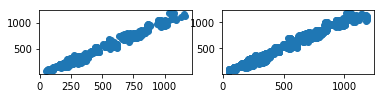

In [53]:
plt.subplot(321)
plt.scatter(pred, y_test)
plt.subplot(322)
plt.scatter(df['Adj. Close'], df['label'])
plt.show()

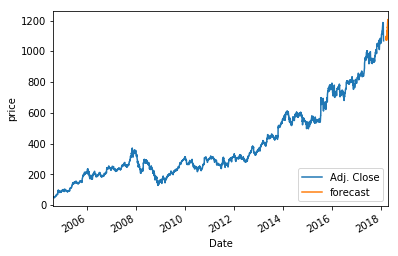

In [55]:
df['forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day
x_lately = x[-forecast_out:]
forecast_set = clf.predict(x_lately)


for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

df['Adj. Close'].plot()
df['forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('price')
plt.show()